## ELO Creation

This notebook is where I calculated ELO rating for each team

## Import and clean data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

regSeason = pd.read_csv("../raw data/RegularSeasonCompactResults.csv")
tournament = pd.read_csv("../raw data/TourneyCompactResults.csv")

In [2]:
# ELO constants
mean_elo = 1500.
elo_width = 400.
k_factor = 64.

In [3]:
df = pd.concat((regSeason, tournament), ignore_index= True)

In [4]:
df.columns

Index([u'Season', u'Daynum', u'Wteam', u'Wscore', u'Lteam', u'Lscore', u'Wloc',
       u'Numot'],
      dtype='object')

In [5]:
df.drop(['Wscore', 'Lscore', 'Wloc', 'Numot'], inplace= True, axis = 1)

In [6]:
df.sort_values(by=['Season', 'Daynum'], inplace=True)

In [8]:
df.head()

,Season,Daynum,Wteam,Lteam
0,1985,20,1228,1328
1,1985,25,1106,1354
2,1985,25,1112,1223
3,1985,25,1165,1432
4,1985,25,1192,1447


## Create ELO Functions

In [9]:
def update_elo(winner_elo, loser_elo):

    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def expected_result(elo_a, elo_b):

    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

In [10]:
def update_end_of_season(elos):

    diff_from_mean = elos - mean_elo
    elos -= diff_from_mean/3.0
    return elos

In [11]:
df['w_elo_before_game'] = 0
df['w_elo_after_game'] = 0
df['l_elo_before_game'] = 0
df['l_elo_after_game'] = 0
elo_per_season = {}
n_teams = len(np.unique(df[['Wteam', 'Lteam']]))
current_elos = np.ones(shape=(n_teams)) * mean_elo

## Create a unique day count

In [12]:
df['total_days'] = (df.Season-1980)*365.25 + df.Daynum

In [13]:
df.head()

,Season,Daynum,Wteam,Lteam,w_elo_before_game,w_elo_after_game,l_elo_before_game,l_elo_after_game,total_days
0,1985,20,1228,1328,0,0,0,0,1846.25
1,1985,25,1106,1354,0,0,0,0,1851.25
2,1985,25,1112,1223,0,0,0,0,1851.25
3,1985,25,1165,1432,0,0,0,0,1851.25
4,1985,25,1192,1447,0,0,0,0,1851.25


In [14]:
df_team_elos = pd.DataFrame(index=df.total_days.unique(), 
                            #columns=range(n_teams))
                            columns = np.unique(df[['Wteam', 'Lteam']]))
df_team_elos.iloc[0, :] = current_elos

In [15]:
df_team_elos.head()

,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
1846.25,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,...,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500
1851.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ELO Loop time

* We go through each row in the DataFrame.
* We look up the current Elo rating of both teams.
* We calculate the expected wins for the team that actually won. This is also what we use for probability of winning.
* Write Elo before and after the game in the Data Frame.
* Update the Elo rating for both teams in the "current_elos" list.

In [17]:
current_season = df.at[0, 'Season']
for row in df.itertuples():
    if row.Season != current_season:
        # Check if we are starting a new season. 
        # Regress all ratings towards the mean
        current_elos = update_end_of_season(current_elos)
        # Write the beginning of new season ratings to a dict for later lookups.
        elo_per_season[row.Season] = current_elos.copy()
        current_season = row.Season
    idx = row.Index
    w_id = row.Wteam
    l_id = row.Lteam
    # Get current elos
    #w_elo_before = current_elos[w_id]
    w_elo_before = current_elos[df_team_elos.columns.get_loc(w_id)]
    #l_elo_before = current_elos[l_id]
    l_elo_before = current_elos[df_team_elos.columns.get_loc(l_id)]
    # Update on game results
    w_elo_after, l_elo_after = update_elo(w_elo_before, l_elo_before)
        
    # Save updated elos
    df.at[idx, 'w_elo_before_game'] = w_elo_before
    df.at[idx, 'l_elo_before_game'] = l_elo_before
    df.at[idx, 'w_elo_after_game'] = w_elo_after
    df.at[idx, 'l_elo_after_game'] = l_elo_after
    current_elos[df_team_elos.columns.get_loc(w_id)] = w_elo_after
    current_elos[df_team_elos.columns.get_loc(l_id)] = l_elo_after
    
    # Save elos to team DataFrame
    today = row.total_days
    df_team_elos.at[today, w_id] = w_elo_after
    df_team_elos.at[today, l_id] = l_elo_after

In [18]:
df.head()

,Season,Daynum,Wteam,Lteam,w_elo_before_game,w_elo_after_game,l_elo_before_game,l_elo_after_game,total_days
0,1985,20,1228,1328,1500,1532,1500,1468,1846.25
1,1985,25,1106,1354,1500,1532,1500,1468,1851.25
2,1985,25,1112,1223,1500,1532,1500,1468,1851.25
3,1985,25,1165,1432,1500,1532,1500,1468,1851.25
4,1985,25,1192,1447,1500,1532,1500,1468,1851.25


In [19]:
n_samples = 10000
samples = df[df.Season > 2010].sample(n_samples)
loss=0
expected_list = []
for row in samples.itertuples():
    w_elo = row.w_elo_before_game
    l_elo = row.l_elo_before_game
    w_expected = expected_result(w_elo, l_elo)
    expected_list.append(w_expected)
    loss += np.log(w_expected)
print(loss/n_samples)

-0.567801683451


<IPython.core.display.Javascript object>


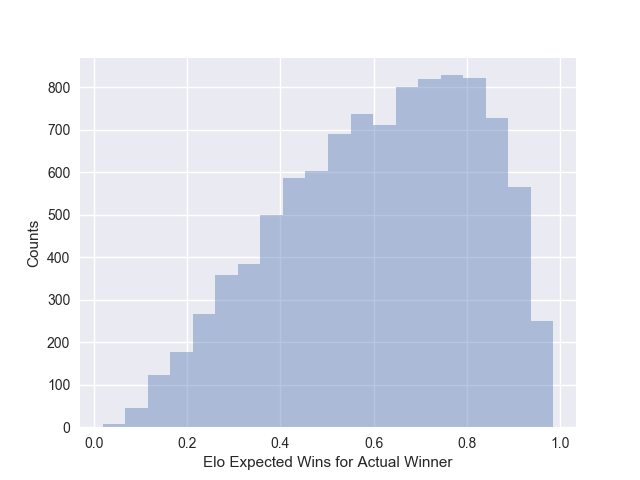

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

sns.distplot(expected_list, kde=False, bins=20)
plt.xlabel('Elo Expected Wins for Actual Winner')
plt.ylabel('Counts')

In [21]:
df_team_elos.head()

,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,...,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464
1846.25,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,...,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500
1851.25,NaN,NaN,NaN,NaN,NaN,1532,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852.25,NaN,1468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1529.06,NaN,NaN,NaN,NaN,NaN,NaN
1854.25,NaN,NaN,NaN,1529.06,NaN,NaN,NaN,NaN,NaN,NaN,...,1494.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1529.06


In [21]:
df.to_csv("../derived data/eloGames.csv")